In [1]:
import os
import glob
import json
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers

import sklearn
from sklearn.model_selection import train_test_split

import librosa as lb
import wave
import pylab
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

In [2]:
BATCH_SIZE=32

In [3]:
# def get_wav_info(wav_file):
#     wav = wave.open(wav_file, 'r')
#     frames = wav.readframes(-1)
#     sound_info = pylab.fromstring(frames, 'int16')
#     frame_rate = wav.getframerate()
#     wav.close()
#     return sound_info, frame_rate

# def graph_spectrogram(wav_file):
#     sound_info, frame_rate = get_wav_info(wav_file)
#     pylab.figure(num=None, figsize=(19, 12))
#     pylab.subplot(111)
#     pylab.title('spectrogram of %r' % wav_file)
#     pylab.specgram(sound_info, Fs=frame_rate)
#     pylab.savefig('spectrogram.png')


In [4]:
""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))

    # zeros at beginning (thus center of 1st window should be for sample nr. 0)   
    samples = np.append(np.zeros(int(np.floor(frameSize/2.0))), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))

    frames = stride_tricks.as_strided(samples, shape=(int(cols), frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win

    return np.fft.rfft(frames)    

""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))

    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):        
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,int(scale[i]):], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,int(scale[i]):int(scale[i+1])], axis=1)

    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[int(scale[i]):])]
        else:
            freqs += [np.mean(allfreqs[int(scale[i]):int(scale[i+1])])]

    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)

    s = stft(samples, binsize)

    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)

    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel

    timebins, freqbins = np.shape(ims)

#     print("timebins: ", timebins)
#     print("freqbins: ", freqbins)

#     plt.figure(figsize=(15, 7.5))
#     plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
#     plt.colorbar()

#     plt.xlabel("time (s)")
#     plt.ylabel("frequency (hz)")
#     plt.xlim([0, timebins-1])
#     plt.ylim([0, freqbins])

#     xlocs = np.float32(np.linspace(0, timebins-1, 5))
#     plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
#     ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
#     plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])

#     if plotpath:
#         plt.savefig(plotpath, bbox_inches="tight")
#     else:
#         plt.show()

#     plt.clf()

    return ims

In [5]:
fake_audio = glob.glob("../input/fake-audio/fake_audio/Fake_audios/*.wav")
original_audio = glob.glob("../input/fake-audio/fake_audio/Original_audios/*.wav")
print(len(fake_audio), len(original_audio))

50 50


In [6]:
# fake_audio_arr = []
# original_audio_arr = []
# for i in range(len(fake_audio)):
#     img = plotstft(fake_audio[i])
#     fake_audio_arr.append(img)
    
# for i in range(len(original_audio)):
#     img = plotstft(original_audio[i])
#     original_audio_arr.append(img)
    
# fake_audio_arr = np.array(fake_audio_arr)
# original_audio_arr = np.array(original_audio_arr)   
# print(fake_audio_arr.shape, original_audio_arr.shape)

In [7]:
train_df = pd.DataFrame(columns=['spectrogram','label'])
for i in range(50):
    train_df=train_df.append({'spectrogram':fake_audio[i],'label':1.0},ignore_index=True)
    train_df=train_df.append({'spectrogram':original_audio[i],'label':0.0},ignore_index=True)
    
train_df.head()

,spectrogram,label
0,../input/fake-audio/fake_audio/Fake_audios/fak...,1.0
1,../input/fake-audio/fake_audio/Original_audios...,0.0
2,../input/fake-audio/fake_audio/Fake_audios/fak...,1.0
3,../input/fake-audio/fake_audio/Original_audios...,0.0
4,../input/fake-audio/fake_audio/Fake_audios/fak...,1.0


In [8]:
X= train_df['spectrogram']
y= train_df['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=23)

In [9]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(75,) (75,) (25,) (25,)


In [10]:
def load_images(files):
    images=[]
    for i in files:
        a = plotstft(i)
#         a = Image.open(i)
        a = np.asarray(a)
        a = cv2.resize(a, (360,360))
        a = np.reshape(a, (360,360,1))
#         a = a/255.0
        images.append(a)
    return np.array(images)

In [11]:
def DataGen(data,label,bsize=BATCH_SIZE):
    while True:
        for i in range(len(data)):
#             rand = np.random.randint(0,len(data)-BATCH_SIZE)
            images = load_images(data[i:i+BATCH_SIZE])
            labels = label[i:i+BATCH_SIZE]
            yield np.array(images),np.array(labels)

In [12]:
train_dataset = DataGen(X_train,y_train)
valid_dataset = DataGen(X_test,y_test)

In [13]:
a,b = next(train_dataset)
c,d = next(valid_dataset)
print(a.shape,b.shape,c.shape,d.shape)

(32, 360, 360, 1) (32,) (25, 360, 360, 1) (25,)


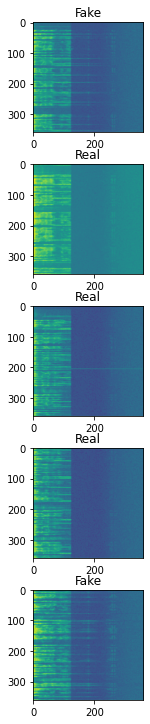

In [14]:
def sample_plot(image,label):
    fig, axs = plt.subplots(5, 1, figsize=(10,10))
    fig.tight_layout()
    for i in range(5):
        
        axs[i].imshow(image[i])
        axs[i].set_title('Real' if label[i]==0.0 else 'Fake')
        
#         axs[i,1].imshow(masks[i])
#         axs[i,1].set_title('Mask')
        
    plt.show()
sample_plot(a,b)

In [15]:
inputs = tf.keras.layers.Input((360,360,1))
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
#   layers.RandomRotation(0.2),
  layers.RandomTranslation(0.1,0.1),
#   layers.RandomContrast(0.1)  
])(inputs)
    
base_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False, weights='imagenet',pooling='max')
base_model.trainable=True
x = base_model(data_augmentation,training=True)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5),tf.keras.metrics.AUC()])

2021-10-27 16:02:53.652299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 16:02:53.746237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 16:02:53.746977: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 16:02:53.749464: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

27033600/27018416 [==============================] - 0s 0us/step


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 1)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 360, 360, 1)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 1280)              6575239   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                20496     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 6,595,752
Trainable params: 6,533,697
Non-trainable params: 62,055
______________________________________________

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('baseline_model.hdf5', monitor='val_auc', verbose=1, save_best_only=True, mode='max')
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy',patience=3,verbose=1,factor=0.5,min_lr=1e-5)
TRAIN_STEPS = 75
VAL_STEPS = 25
EPOCHS = 5
history = model.fit(train_dataset, steps_per_epoch=TRAIN_STEPS,validation_data=(valid_dataset),validation_steps=VAL_STEPS,
                    batch_size=BATCH_SIZE,epochs=EPOCHS, 
#                     callbacks = [checkpoint,lr_reducer]
                   )

2021-10-27 16:03:01.307386: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2021-10-27 16:03:14.198197: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


75/75 [==============================] - 143s 2s/step - loss: 0.1901 - binary_accuracy: 0.9632 - auc: 0.9848 - val_loss: 0.0057 - val_binary_accuracy: 0.9969 - val_auc: 1.0000
Epoch 2/5
75/75 [==============================] - 106s 1s/step - loss: 0.0377 - binary_accuracy: 0.9900 - auc: 0.9980 - val_loss: 0.0045 - val_binary_accuracy: 0.9969 - val_auc: 1.0000
Epoch 3/5
75/75 [==============================] - 107s 1s/step - loss: 0.0143 - binary_accuracy: 0.9984 - auc: 0.9995 - val_loss: 0.0551 - val_binary_accuracy: 0.9938 - val_auc: 0.9975
Epoch 4/5
75/75 [==============================] - 107s 1s/step - loss: 0.0064 - binary_accuracy: 0.9984 - auc: 0.9995 - val_loss: 0.0291 - val_binary_accuracy: 0.9969 - val_auc: 0.9975
Epoch 5/5
75/75 [==============================] - 106s 1s/step - loss: 1.9740e-04 - binary_accuracy: 1.0000 - auc: 1.0000 - val_loss: 0.0012 - val_binary_accuracy: 1.0000 - val_auc: 1.0000


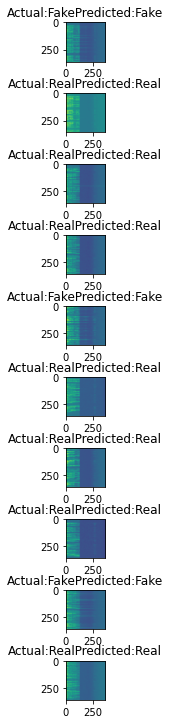

In [18]:
def test_plot(image,label):
    fig, axs = plt.subplots(10, 1, figsize=(10,10))
    fig.tight_layout()
    for i in range(10):
        y_pred = model.predict(np.reshape(image[i],(1,360,360,1)))
        y_pred = 1.0 if y_pred>0.5 else 0.0
        y_pred_l= 'Real' if y_pred==0.0 else 'Fake'
        y_true_l = 'Real' if label[i]==0.0 else 'Fake'
        axs[i].imshow(image[i])
        axs[i].set_title('Actual:'+y_true_l+'Predicted:'+y_pred_l)
        
#         axs[i,1].imshow(masks[i])
#         axs[i,1].set_title('Mask')
        
    plt.show()
test_plot(a,b)

In [19]:
model.save('baseline.hdf5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
